<a href="https://colab.research.google.com/github/ahnjj/AI/blob/master/multiagent_rag_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-agent RAG System 🤖🤝🤖

_Authored by: [Sergio Paniego](https://github.com/sergiopaniego)_

🚨 **NOTE**: This tutorial is advanced. You should have a solid understanding of the concepts discussed in the following cookbooks before diving in:
- [Agents Cookbook](agents)
- [Advanced RAG Cookbook](advanced_rag)

In this notebook, we will create a **multi-agent RAG system**, a system where multiple agents work together to retrieve and generate information, combining the strengths of **retrieval-based systems** and **generative models**.

## What is a Multi-agent RAG System? 🤔

A **Multi-agent Retrieval-Augmented Generation (RAG)** system consists of multiple agents that collaborate to perform complex tasks. The retrieval agent retrieves relevant documents or information, while the generative agent synthesizes that information to generate meaningful outputs. There is a Manager Agent that orchestrates the system and selects the most appropriate agent for the task based on the user input.

The original idea for this recipe comes from [this post](https://weaviate.io/blog/what-is-agentic-rag). You may find more details about it there.

Below, you can find the architecture that we will build.


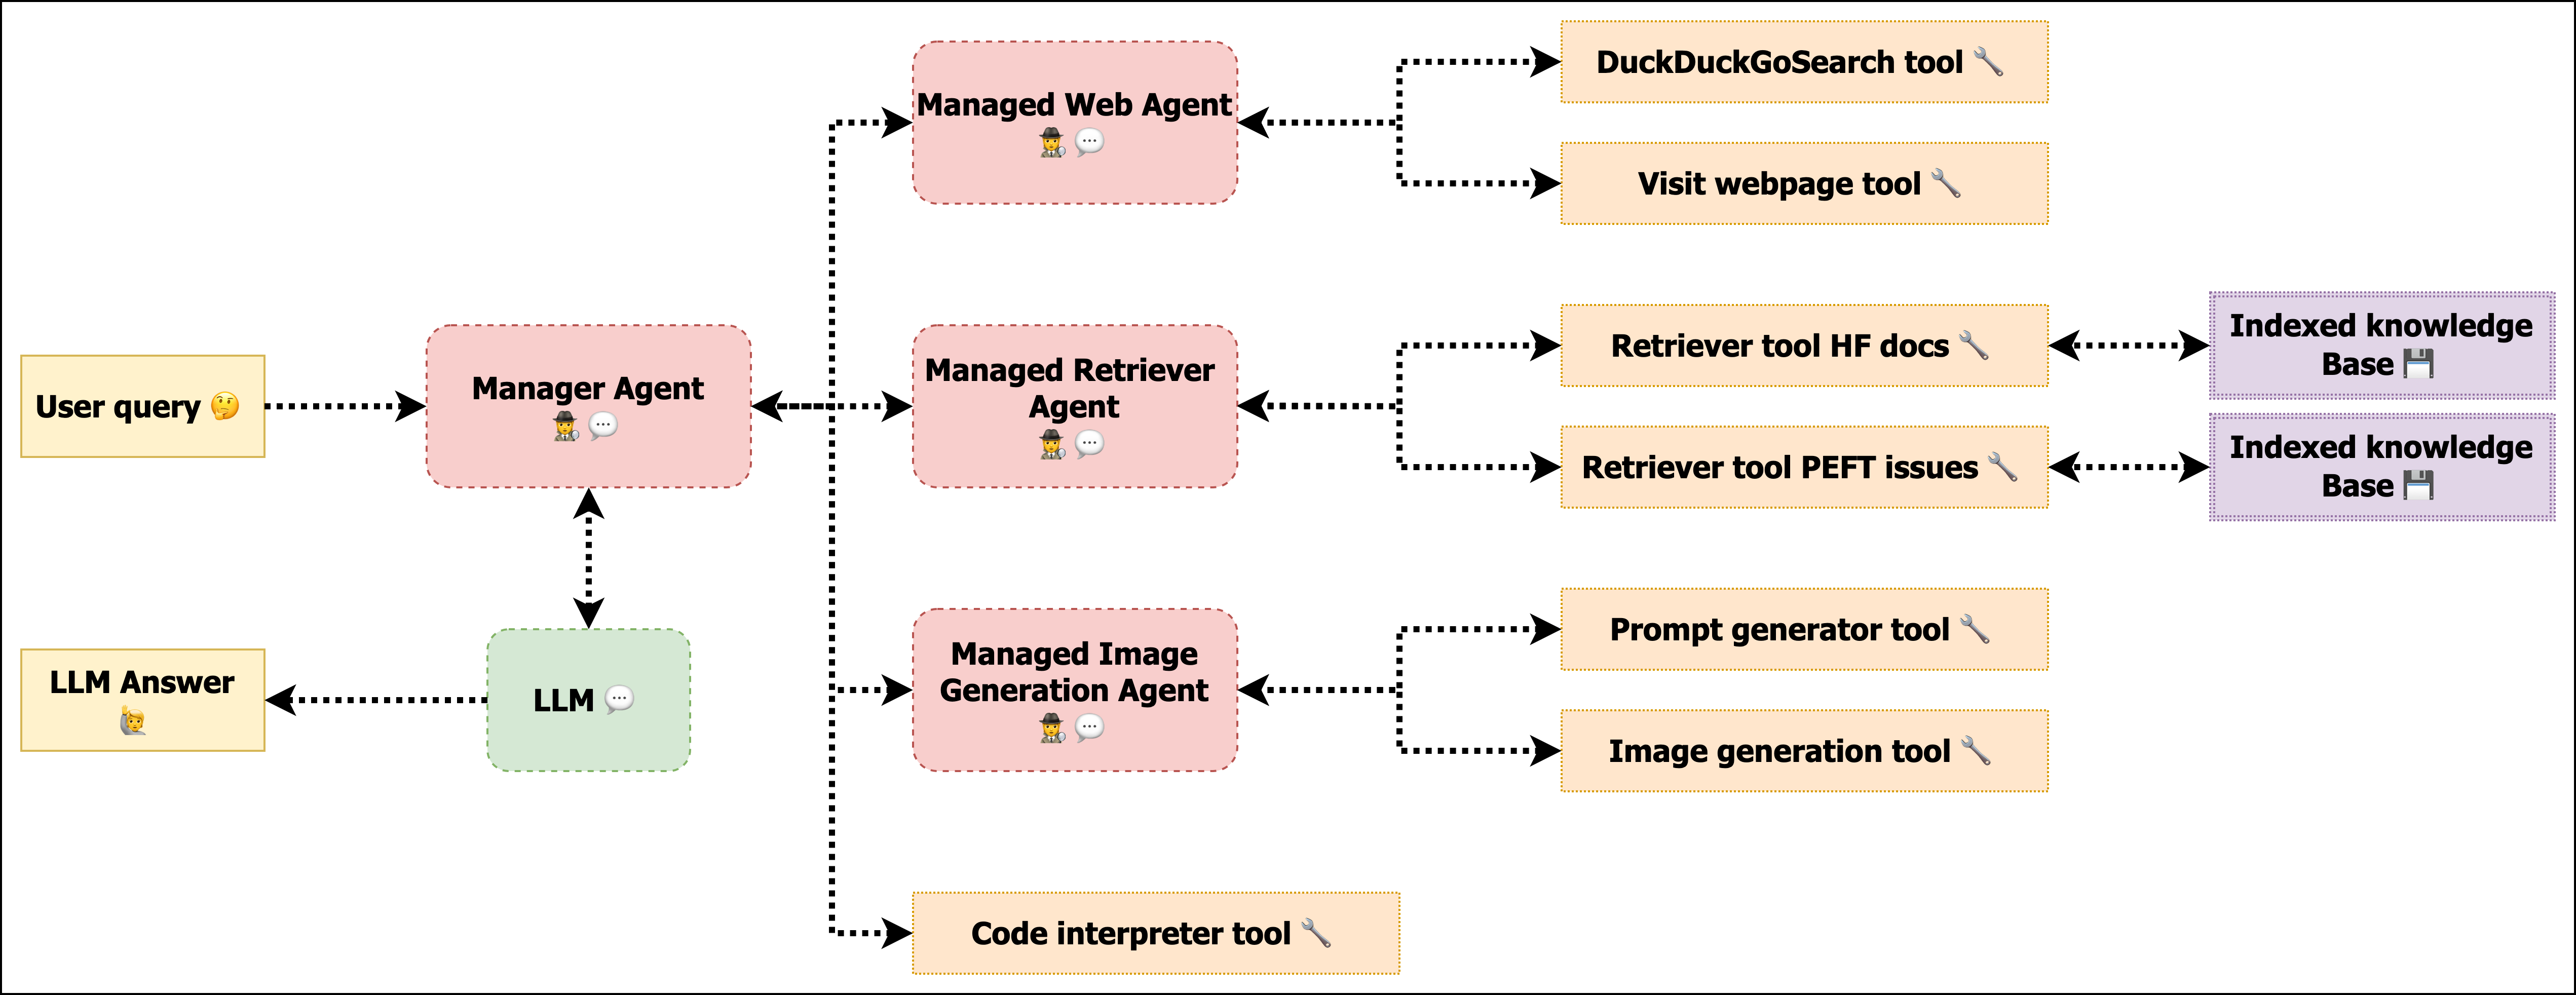

## 1. Install dependencies

First, let's install the dependencies:

In [ ]:
!pip install -q smolagents

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.3/105.3 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 94.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 71.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.


In [ ]:
!pip install markdownify duckduckgo-search spaces gradio-tools langchain langchain-community langchain-huggingface faiss-cpu --upgrade -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 29.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 69.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.2/322.2 kB 29.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.3/51.3 MB 43.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 101.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 106.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 82.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8

Let's login in order to call the HF Inference API:

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

# 2. Let's create our multi-agent RAG system

In this section, we will create each of the agents present in our RAG system.

We will have 3 agents managed by a central one (refer to the image for details):

* **🕵💬 Web search agent**: It will include the [`DuckDuckGoSearchTool`](https://github.com/huggingface/transformers/blob/main/src/transformers/agents/search.py) tool and the [`VisitWebpageTool`](https://github.com/huggingface/transformers/blob/main/src/transformers/agents/search.py). As you can see, each agent may contain a list of tools.
* **🕵💬 Retriever agent**: It will include two tools for retrieving information from two different knowledge bases.
* **🕵💬 Image generation agent**: It will include a prompt generator tool in addition to the image generation tool.

💡 In addition to these agents, the **central/orchestrator agent** will also have access to the **code interpreter tool** to execute code.

We will use [Qwen/Qwen2.5-72B-Instruct](https://huggingface.co/Qwen/Qwen2.5-72B-Instruct) as the LLM for each component, which will be accessed via the Inference API. Depending on the agent, a different LLM model may be used.

> _Note:_ The Inference API hosts models based on various criteria, and deployed models may be updated or replaced without prior notice. Learn more about it [here](https://huggingface.co/docs/api-inference/supported-models).



In [ ]:
from smolagents import HfApiModel

model_id = "Qwen/Qwen2.5-72B-Instruct"
model = HfApiModel(model_id)

Let's dive into the details of each agent!

### 2.1 Web search agent 🔍

The **Web search agent** will utilize the [`DuckDuckGoSearchTool`](https://github.com/huggingface/transformers/blob/main/src/transformers/agents/search.py) to search the web and gather relevant information. This tool acts as a search engine, querying for results based on the specified keywords.

To make the search results actionable, we also need the agent to access the web pages retrieved by DuckDuckGo. That can be achieved by using the built-in [`VisitWebpageTool`](https://github.com/huggingface/transformers/blob/main/src/transformers/agents/search.py).

Let’s explore how to set it up and integrate it into our system!

The following code comes from the original [Have several agents collaborate in a multi-agent hierarchy 🤖🤝🤖](https://huggingface.co/learn/cookbook/multiagent_web_assistant) recipe, so refer to it for more details.





#### 2.1.1 Build our multi-tool web agent 🤖

Now that we've set up the basic search and webpage tools, let's build our **multi-tool web agent**. This agent will combine several tools to perform more complex tasks, leveraging the capabilities of the `ToolCallingAgent`.

The `ToolCallingAgent` is particularly well-suited for web search tasks because its JSON action formulation requires only simple arguments and works seamlessly in sequential chains of single actions. This makes it an excellent choice for scenarios where we need to search the web for relevant information and retrieve detailed content from specific web pages. In contrast, `CodeAgent` action formulation is better suited for scenarios involving numerous or parallel tool calls.

By integrating multiple tools, we can ensure that our agent interacts with the web in a sophisticated and efficient manner.

Let's dive into how to set this up and integrate it into our system!



In [ ]:
from smolagents import CodeAgent, ToolCallingAgent, DuckDuckGoSearchTool, VisitWebpageTool

# web agent
web_agent = ToolCallingAgent(
    tools=[DuckDuckGoSearchTool(), VisitWebpageTool()],
    model=model,
    name='web_agent',
    description='Browse web'
)

Now that we have our first agent, let's wrap it as a `ManagedAgent` so the central agent can use it.

In [ ]:
# central agent로 감싸고 web_agent 던져주기
managed_web_agent = CodeAgent(
    model=model,
    tools = [],
    managed_agents=[web_agent], # All managed agents need both a name and a description!
    name="search_agent",
    description="Runs web searches for you. Give it your query as an argument.",
)

In [ ]:
# managed_web_agent = ManagedAgent(
#     agent=web_agent,
#     name="search_agent",
#     description="Runs web searches for you. Give it your query as an argument.",
# )

### 2.2 Retriever agent 🤖🔍

The second agent in our multi-agent system is the **Retriever agent**. This agent is responsible for gathering relevant information from different sources. To achieve this, it will utilize two tools that retrieve data from two separate knowledge bases.

We will reuse two data sources that were previously used in other RAG recipes, which will allow the retriever to efficiently gather information for further processing.

By leveraging these tools, the Retriever agent can access diverse datasets, ensuring a comprehensive collection of relevant information before passing it on to the next step in the system.

Let's explore how to set up the retriever and integrate it into our multi-agent system!


#### 2.2.1 HF docs retriever tool 📚

The first retriever tool comes from the [Agentic RAG: turbocharge your RAG with query reformulation and self-query! 🚀](https://huggingface.co/learn/cookbook/agent_rag) recipe.

For this retriever, we will use a dataset that contains a compilation of documentation pages for various `huggingface` packages, all stored as markdown files. This dataset serves as the knowledge base for the retriever agent to search and retrieve relevant documentation.

To make this dataset easily accessible for our agent, we will:

1. **Download the dataset**: We will first fetch the markdown documentation.
2. **Embed the data**: We will then convert the documentation into embeddings using a **FAISS vector store** for efficient similarity search.

By doing this, the retriever tool can quickly access the relevant pieces of documentation based on the search query, enabling the agent to provide accurate and detailed information.

Let’s go ahead and set up the tool to handle the documentation retrieval!



In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 22.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 22.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.0
    Uninstalling fsspec-2025.3.0:
      Successfully uninstalled fsspec-2025.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.0 requires fsspec==2025.3.0, but you have fsspec 2024.12.0 which is incompatible.


In [ ]:
import datasets

knowledge_base = datasets.load_dataset("m-ric/huggingface_doc", split="train")

README.md:   0%|          | 0.00/21.0 [00:00<?, ?B/s]

huggingface_doc.csv:   0%|          | 0.00/22.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2647 [00:00<?, ? examples/s]

In [ ]:
from tqdm import tqdm
from transformers import AutoTokenizer
from langchain.docstore.document import Document
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import FAISS
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.vectorstores.utils import DistanceStrategy

source_docs = [
    Document(page_content=doc["text"], metadata={"source": doc["source"].split("/")[1]})
    for doc in knowledge_base
]

text_splitter = RecursiveCharacterTextSplitter.from_huggingface_tokenizer(
    AutoTokenizer.from_pretrained("thenlper/gte-small"),
    chunk_size=200,
    chunk_overlap=20,
    add_start_index=True,
    strip_whitespace=True,
    separators=["\n\n", "\n", ".", " ", ""],
)

# 문서 구분자로 쪼개서 중복 없이 저장
print("Splitting documents...")
docs_processed = []
unique_texts = {}
for doc in tqdm(source_docs):
    new_docs = text_splitter.split_documents([doc])
    for new_doc in new_docs:
        if new_doc.page_content not in unique_texts:
            unique_texts[new_doc.page_content] = True
            docs_processed.append(new_doc)

# 저장된 문서 조각 임베딩으로 변환
print("Embedding documents...")
embedding_model = HuggingFaceEmbeddings(model_name="thenlper/gte-small")
huggingface_doc_vector_db = FAISS.from_documents(   # FAISS: facebook에서 만든 고차원 벡터 계산 라이브러리
    documents=docs_processed,
    embedding=embedding_model,
    distance_strategy=DistanceStrategy.COSINE,
)

tokenizer_config.json:   0%|          | 0.00/394 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

Splitting documents...


100%|██████████| 2647/2647 [01:20<00:00, 32.84it/s]


Embedding documents...


modules.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/68.1k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/583 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/66.7M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Now that we have the documentation embedded in FAISS, let's create the **RetrieverTool**. This tool will query the FAISS vector store to retrieve the most relevant documents based on the user’s query.

This will allow the retriever agent to access and provide relevant documentation when queried.



In [ ]:
from smolagents import Tool
from langchain_core.vectorstores import VectorStore

# 만든 툴
class RetrieverTool(Tool):
    # name = "retriever"
    description = "Using semantic similarity, retrieves some documents from the knowledge base that have the closest embeddings to the input query."
    inputs = {
        "query": {
            "type": "string",
            "description": "The query to perform. This should be semantically close to your target documents. Use the affirmative form rather than a question.",
        }
    }
    output_type = "string"

    def __init__(self, vectordb: VectorStore, name, **kwargs):
        super().__init__(**kwargs)
        self.vectordb = vectordb
        self.name = name

    def forward(self, query: str) -> str:
        assert isinstance(query, str), "Your search query must be a string"

        docs = self.vectordb.similarity_search(
            query,
            k=7,
        )

        return "\nRetrieved documents:\n" + "".join(
            [
                f"===== Document {str(i)} =====\n" + doc.page_content
                for i, doc in enumerate(docs)
            ]
        )

In [ ]:
huggingface_doc_retriever_tool = RetrieverTool(huggingface_doc_vector_db, name = "huggingface doc retriever")

#### 2.2.2 PEFT issues retriever tool

For the second retriever, we will use the [PEFT issues](https://github.com/huggingface/peft/issues) as data source as in the [Simple RAG for GitHub issues using Hugging Face Zephyr and LangChain](https://huggingface.co/learn/cookbook/rag_zephyr_langchain).

Again, the following code comes from that recipe so refer to it for more details!

In [ ]:
from google.colab import userdata
GITHUB_ACCESS_TOKEN = userdata.get('GITHUB_PERSONAL_TOKEN')

In [ ]:
from langchain.document_loaders import GitHubIssuesLoader

# peft 레포의 이슈들을 불러온다
loader = GitHubIssuesLoader(repo="huggingface/peft", access_token=GITHUB_ACCESS_TOKEN, include_prs=False, state="all")
docs = loader.load()

In [ ]:
splitter = RecursiveCharacterTextSplitter(chunk_size=512, chunk_overlap=30)
chunked_docs = splitter.split_documents(docs) # 문서 청킹

In [ ]:
peft_issues_vector_db = FAISS.from_documents(chunked_docs, embedding=embedding_model) # 청킹한 문서들 임베딩

Let's now generate the second retriever tool using the same `RetrieverTool`.

In [ ]:
peft_issues_retriever_tool = RetrieverTool(peft_issues_vector_db, name="peft retriever tool")

#### 2.2.3 Build the Retriever agent

Now that we’ve created the two retriever tools, it’s time to build the **Retriever agent**. This agent will manage both tools and retrieve relevant information based on the user query.

We’ll use the `ManagedAgent` to integrate these tools and pass the agent to the central agent for coordination.


In [ ]:
# 만든 retriever 툴 2개를 agent에 도구로 던져준다
retriever_agent = ToolCallingAgent(
    name="retriever tool calling agent",
    description = "retriever tool calling agent",
    tools=[huggingface_doc_retriever_tool, peft_issues_retriever_tool], model=model
)

In [ ]:
from smolagents import CodeAgent, ToolCallingAgent, DuckDuckGoSearchTool, VisitWebpageTool
managed_retriever_agent = CodeAgent(
    model = model,
    tools = [],
    managed_agents = [retriever_agent],
    name="retriever_agent",
    description="Retrieves documents from the knowledge base for you that are close to the input query. Give it your query as an argument. The knowledge base includes Hugging Face documentation and PEFT issues.",
)

### 2.3 Image generation agent 🎨

The third agent in our system is the **Image generation agent**. This agent will have two tools: one for refining the user query and another for generating the image based on the query. In this case, we will use the `CodeAgent` instead of a `ReactAgent` since the set of actions can be executed in one shot.

You can find more details about the image generation agent in the [Agents, supercharged - Multi-agents, External tools, and more](https://huggingface.co/docs/transformers/en/agents_advanced) documentation.

Let’s dive into how these tools will work together to generate images based on user input!




In [ ]:
from transformers import load_tool, CodeAgent
# 쿼리 만드는 툴
prompt_generator_tool = Tool.from_space("sergiopaniego/Promptist", name="generator_tool", description="Optimizes user input into model-preferred prompts")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_deprecation.py:131: FutureWarning: '__init_subclass__' (from 'transformers.agents.tools') is deprecated and will be removed from version '4.51.0'. Switch to smolagents instead, with the same functionalities and similar API (https://huggingface.co/docs/smolagents/index)
  warnings.warn(warning_message, FutureWarning)


Loaded as API: https://sergiopaniego-promptist.hf.space ✔


In [ ]:
!git clone https://huggingface.co/spaces/m-ric/text-to-image

Cloning into 'text-to-image'...
remote: Enumerating objects: 43, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 43 (delta 6), reused 0 (delta 0), pack-reused 28 (from 1)
Unpacking objects: 100% (43/43), 13.88 KiB | 1.39 MiB/s, done.


In [ ]:
cd text-to-image

/content/text-to-image


In [ ]:
pip install -r requirements.txt

In [ ]:
# 쿼리를 바탕으로 이미지 생성하는 툴
image_generation_tool = load_tool("m-ric/text-to-image", trust_remote_code=True)
image_generation_agent = CodeAgent(tools=[prompt_generator_tool, image_generation_tool], model=model, name='image generation agent', description='generate image from text')
# image_generation_agent = CodeAgent(tools=[prompt_generator_tool, image_generation_tool], model=model, name='image generation agent', description='generate image from text')

NameError: name 'load_tool' is not defined

🖼 Again, we use `ManagedAgent` to tell the central agent that it can manage it. Additionally, we’ve included an `additional_prompting` parameter to ensure the agent returns the generated image instead of just a text description.

In [ ]:
managed_image_generation_agent = CodeAgent(
    managed_agent=[image_generation_agent],
    name="image_generation_agent",
    description="Generates images from text prompts. Give it your prompt as an argument.",
    additional_prompting="\n\nYour final answer MUST BE only the generated image location."
)

NameError: name 'image_generation_agent' is not defined

## 3. Let's add the general agent manager to orchestrate the system

The **central agent manager** will coordinate tasks between the agents. It will:

- **Receive user input** and decide which agent (Web search, Retriever, Image generation) handles it.
- **Delegate tasks** to the appropriate agent based on the user's query.
- **Collect and synthesize** results from the agents.
- **Return the final output** to the user.

We include all the agents we’ve developed as `managed_agents` and add any necessary imports for the code executor under `additional_authorized_imports`.

In [ ]:
manager_agent = CodeAgent(
    tools=[],
    model=model,
    managed_agents=[managed_web_agent, managed_retriever_agent], # , managed_image_generation_agent
    additional_authorized_imports=["time", "datetime", "PIL"],
)

Now that everything is set up, let's test the performance of the multi-agent RAG system!

To do so, we'll provide some example queries and observe how the system delegates tasks between the agents, processes the information, and returns the final results.

This will help us understand the efficiency and effectiveness of our agents working together, and identify areas for optimization if necessary.

Let's go ahead and run some tests!

### 3.1 Example trying to trigger the search agent

In [ ]:
manager_agent.run("How many years ago was Stripe founded?")

╭──────────────────────────────────────────────────── New run ────────────────────────────────────────────────────╮
│                                                                                                                 │
│ How many years ago was Stripe founded?                                                                          │
│                                                                                                                 │
╰─ HfApiModel - Qwen/Qwen2.5-72B-Instruct ────────────────────────────────────────────────────────────────────────╯

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 1 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Error in generating model output:
402 Client Error: Payment Required for url: 
https://router.huggingface.co/hf-inference/models/Qwen/Qwen2.5-72B-Instruct/v1/chat/completions (Request ID: 
Root=1-67e39688-2e14201f017a6b6970ebbbe7;98f3f36e-008f-44e3-963c-c1a5181803dd)

You have exceeded your monthly included credits for Inference Providers. Subscribe to PRO to get 20x more monthly 
included credits.

[Step 1: Duration 0.36 seconds]

AgentGenerationError: Error in generating model output:
402 Client Error: Payment Required for url: https://router.huggingface.co/hf-inference/models/Qwen/Qwen2.5-72B-Instruct/v1/chat/completions (Request ID: Root=1-67e39688-2e14201f017a6b6970ebbbe7;98f3f36e-008f-44e3-963c-c1a5181803dd)

You have exceeded your monthly included credits for Inference Providers. Subscribe to PRO to get 20x more monthly included credits.

### 3.2 Example trying to trigger the image generator agent

In [ ]:
result = manager_agent.run(
    "Improve this prompt, then generate an image of it.", prompt='A rabbit wearing a space suit'
)

TypeError: MultiStepAgent.run() got an unexpected keyword argument 'prompt'

In [ ]:
from IPython.display import Image, display
display(Image(filename=result))

### 3.3 Example trying to trigger the retriever agent for the HF docs knowledge base

In [ ]:
manager_agent.run("How can I push a model to the Hub?")

### 3.4 Example trying to trigger the retriever agent for the PEFT issues knowledge base

In [ ]:
manager_agent.run("How do you combine multiple adapters in peft?")

🏁 **Final Thoughts**

We have successfully built a multi-agent RAG system that integrates Web Search, Document Retrieval, and Image Generation agents, all orchestrated by a central agent manager. This architecture enables seamless task delegation, efficient processing, and the flexibility to handle a wide variety of user queries.

🔍 **Explore More**

- [Agents Cookbook](agents)
- [Advanced RAG Cookbook](advanced_rag)
- [More Cookbooks](https://huggingface.co/learn/cookbook/index)
- [Learn more about Agentic RAG](https://weaviate.io/blog/what-is-agentic-rag)
